# Explore Variant Assignments

**Gregory Way, 2018**

There are several different variants observed in the PPTC dataset.
Here, I visualize and determine the scores across these variants.

## Output

The output of this notebook are several figures and tables describing the classifier scores across variants and confidence scores.

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from utils import vis_classifier_scores, extract_outliers

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

In [4]:
# Load classifier information with variants
file = os.path.join("results", "classifier_scores_with_variants.tsv")

scores_df = pd.read_table(file)
scores_df.head(2)

,Model,TSB,Hugo_Symbol,classifier,Chromosome,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,...,dbNSFP_SIFT_pred,Fusion,Have.snp.file,Have.maf,Have.fpkm.file,sample_id,ras_score,tp53_score,nf1_score,Histology.Detailed
0,ALL-02,NaN,CDKN2A,TP53,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,ALL-02,0.443316,0.316616,0.412882,BCP-ALL
1,ALL-03,TARGET-10-PPT086-60A-01D-human,ALK,ras,2.0,30143482.0,30143482.0,G,G,T,...,.,NaN,yes,yes,yes,ALL-03,0.704373,0.123663,0.506005,MLL-ALL


In [5]:
# Load full classifier information (includes wild-type samples)
file = os.path.join("results", "classifier_scores_with_clinical_and_alterations.tsv")

full_scores_df = pd.read_table(file)
full_scores_df.head(2)

,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,Phase,PersonID,DNA.Part.of.PPTC,...,KRAS,MDM2,NF1,NRAS,PTPN11,RB1,TP53,nf1_status,ras_status,tp53_status
0,ALL-02,0.443316,0.316616,0.412882,0.635730,0.741554,0.487739,Relapse,P0001,yes,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,ALL-03,0.704373,0.123663,0.506005,0.534187,0.642659,0.553189,Diagnosis,P0002,yes,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [6]:
# Extract scores for each variant
ras_genes = ['ALK', 'NF1', 'PTPN11', 'BRAF', 'KRAS', 'HRAS', 'NRAS']
tp53_genes = ["TP53", "RB1", "CHEK2", "MDM2"]

ras_scores_df = scores_df.query("Hugo_Symbol in @ras_genes")
nf1_scores_df = scores_df.query("Hugo_Symbol == 'NF1'")
tp53_scores_df = scores_df.query("Hugo_Symbol == @tp53_genes")

In [7]:
# Extract out wild-type samples and rename columns
ras_wildtype_df = (
    full_scores_df
    .query("ras_status == 0")
    .loc[:, ['sample_id', 'ras_score', 'Histology.Detailed']]
)

nf1_wildtype_df = (
    full_scores_df
    .query("nf1_status == 0")
    .loc[:, ['sample_id', 'nf1_score', 'Histology.Detailed']]
)

tp53_wildtype_df = (
    full_scores_df
    .query("tp53_status == 0")
    .loc[:, ['sample_id', 'tp53_score', 'Histology.Detailed']]
)

In [8]:
# Merge data for downstream plotting
sub_cols = ['Variant_Classification', 'Hugo_Symbol']

ras_df = (
    ras_wildtype_df
    .merge(ras_scores_df, how='outer', on=['sample_id', 'ras_score', 'Histology.Detailed'])
)
ras_df.loc[:, sub_cols] = ras_df.loc[:, sub_cols].fillna(value='wild-type')

nf1_df = (
    nf1_wildtype_df
    .merge(nf1_scores_df, how='outer', on=['sample_id', 'nf1_score', 'Histology.Detailed'])
)
nf1_df.loc[:, sub_cols] = nf1_df.loc[:, sub_cols].fillna(value='wild-type')

tp53_df = (
    tp53_wildtype_df
    .merge(tp53_scores_df, how='outer', on=['sample_id', 'tp53_score', 'Histology.Detailed'])
)
tp53_df.loc[:, sub_cols] = tp53_df.loc[:, sub_cols].fillna(value='wild-type')

## 1. Visualize classifier scores across genes

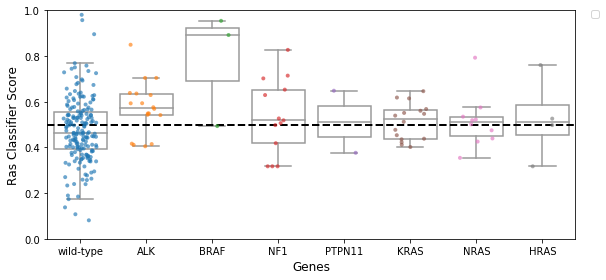

In [9]:
vis_classifier_scores(df=ras_df,
                      gene='Ras',
                      rcparam=(8.5, 4))

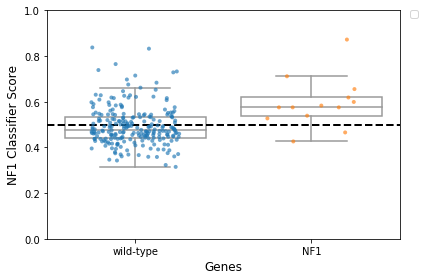

In [10]:
vis_classifier_scores(df=nf1_df, gene='NF1')

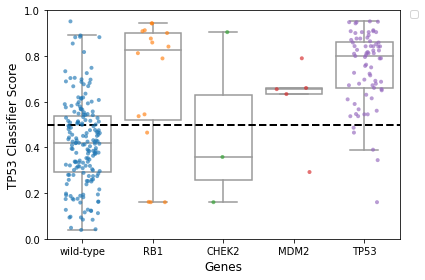

In [11]:
vis_classifier_scores(df=tp53_df,
                      gene='TP53')

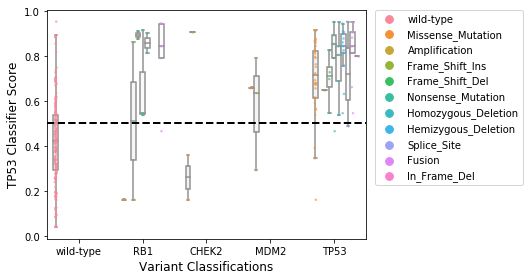

In [12]:
# Plot different variant classifications across TP53
file = os.path.join('figures', 'TP53_variant_classification.pdf')

plt.figure(figsize=(7.5, 4))
ax = sns.boxplot(x='Hugo_Symbol',
                 y='tp53_score',
                 data=tp53_df,
                 hue='Variant_Classification',
                 color='white',
                 fliersize=0)

ax = sns.stripplot(x='Hugo_Symbol',
                   y='tp53_score',
                   data=tp53_df,
                   hue='Variant_Classification',
                   dodge=True,
                   edgecolor='black',
                   jitter=0.15,
                   size=2.5,
                   alpha=0.65)

ax.set_ylabel('TP53 Classifier Score', fontsize=12)
ax.set_xlabel('Variant Classifications', fontsize=12)
handles, labels = ax.get_legend_handles_labels()

lgd = plt.legend(handles[11:35], labels[11:35],
                 ncol=1,
                 bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig(file, dpi=400)

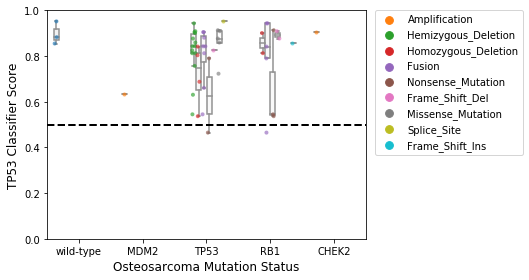

In [13]:
# Visualize Osteosarcoma Specifically
osteo_df = tp53_df[tp53_df["Histology.Detailed"] == "Osteosarcoma"]
file = os.path.join('figures', 'TP53_osteosarcoma_variant_classification.pdf')

plt.figure(figsize=(7.5, 4))
ax = sns.boxplot(x='Hugo_Symbol',
                 y='tp53_score',
                 data=osteo_df,
                 hue='Variant_Classification',
                 color='white',
                 fliersize=0)

ax = sns.stripplot(x='Hugo_Symbol',
                   y='tp53_score',
                   data=osteo_df,
                   hue='Variant_Classification',
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylim([0, 1])
ax.set_ylabel('TP53 Classifier Score', fontsize=12)
ax.set_xlabel('Osteosarcoma Mutation Status', fontsize=12)
handles, labels = ax.get_legend_handles_labels()

lgd = plt.legend(handles[11:26], labels[11:26],
                 ncol=1,
                 bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig(file)

## 2. Extract Outliers

These are false positive and false negative samples.

In [14]:
# What are the outliers in TP53 mutated samples?
tp53_outlier_df = extract_outliers(df=tp53_df, gene='TP53')

In [15]:
# What are the outliers in Ras mutated samples?
ras_outlier_df = extract_outliers(df=ras_df, gene='Ras')

In [16]:
# What are the outliers in NF1 mutated samples?
nf1_outlier_df = extract_outliers(df=nf1_df, gene='NF1')

In [17]:
# Combine outliers into single dataframe
full_outlier_df = (
    pd.concat(
        [tp53_outlier_df, ras_outlier_df, nf1_outlier_df],
        axis='rows'
    )
    .sort_values(by='classifier_score', ascending=False)
    .drop_duplicates()
    .reset_index(drop=True)
    .rename({'hugo_symbol': 'classifier_gene'}, axis='columns')
)

full_outlier_df.head()

,sample_id,classifier_score,histology,classifier_gene,true_status
0,NCH-RBD-2,0.980707,Extracranial Rhabdoid,Ras,wild-type
1,OS-49-SJ,0.957352,Osteosarcoma,Ras,wild-type
2,OS-34-SJ,0.951862,Osteosarcoma,TP53,wild-type
3,IC-6634GBM,0.895805,Glioblastoma,Ras,wild-type
4,IC-2664PNET,0.890375,Astrocytoma,TP53,wild-type


In [18]:
file = os.path.join("results", "outlier_predictions_ras_tp53_nf1.tsv")
full_outlier_df.to_csv(file, sep='\t', index=False)